# Prototypical Networks 

A implementaçao foi baseada num notebook de exemplo `easyfsl` e está em `methods/prototypical_networks.py`

O código que esta no git e usável quando importamos a lib está desatualizado ou nao funciona ;-;

Não consegui instalar o `learn2learn` de jeito nenhum

Dúvidas
- Precisamos verificar se os parametros estão de acordo com o paper 
- Faz sentido treinar por 1000 epocas (mesmo que outer-loop-updates)? 
- Como fazer o modelo generalizar melhor nas tasks de teste? É normal em FSL o teste ser tão abaixo do treinamento, já que são classes completamente diferentes? Tive muito problema com Oveffiting

In [2]:
import time
import timm
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from data.data_manager import BRSETManager
from methods.prototypical_network import PrototypicalNetworks

In [3]:
TRAINING_CLASSES = ['diabetic_retinopathy',
                        'scar', 'amd', 'hypertensive_retinopathy', 'drusens', 
                        'myopic_fundus', 'increased_cup_disc', 'other']
TEST_CLASSES = ['hemorrhage', 'vascular_occlusion', 'nevus', 'healthy']

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Parametros

In [6]:
ways = 2
shots = 5
model_type = 'resnet50.a3_in1k'

É importante que todas as imagens de treinamento sejas usadas para gerar o prototype

In [7]:
batch_size = ways*shots

## Dataloader

In [8]:
if model_type == "resnet50.a3_in1k" or model_type == "swin_s3_tiny_224.ms_in1k": 
    mean_val, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif model_type == "vit_small_patch32_224.augreg_in21k_ft_in1k":
    mean_val, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
manager = BRSETManager(TRAINING_CLASSES, TEST_CLASSES, shots, ways, mean_val, std, 
                       augment=None, batch_size=batch_size, seed=seed)

## Modelo

In [10]:
backbone = timm.create_model(model_type, pretrained=True)
backbone.reset_classifier(num_classes=0) # remove a head do modelo

model = PrototypicalNetworks(backbone).to(device)

## Treinamento

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

log_every_n_epochs = 100
epochs = 500

In [12]:
logging = []
interval_loss = 0
interval_acc = 0

model.train()
start_time = time.time()
for epoch in range(epochs):
    # pega uma task usando classes de TREINAMENTO
    train_loader, test_loader, classes = manager.get_eval_task(train_classes=True)

    for train_batch, query_batch in zip(train_loader, test_loader):
        # esse loop so roda 1 vez pois batch_size = ways*shots
        train_imgs, train_labels = train_batch
        query_imgs, query_labels = query_batch

        # remove one-hot encoding das labels
        train_labels = train_labels.argmax(1)
        query_labels = query_labels.argmax(1)

        train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
        query_imgs, query_labels = query_imgs.to(device), query_labels.to(device)

        scores = model(train_imgs, train_labels, query_imgs)

        # add l2 regularization
        l2_reg = 0
        for param in model.parameters():
            l2_reg += torch.norm(param)

        loss = criterion(scores, query_labels) + 1e-4 * l2_reg
        
        interval_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (scores.argmax(1) == query_labels).float().mean().item()
        interval_acc += acc

    # log das metricas
    if (epoch + 1) % log_every_n_epochs == 0:
        mean_interval_loss = interval_loss / log_every_n_epochs
        mean_interval_acc = interval_acc / log_every_n_epochs

        print(f"Epochs {epoch - log_every_n_epochs + 2}-{epoch + 1} - Loss: {mean_interval_loss:.3f} - Acc: {mean_interval_acc:.2f}")
        logging.append((epoch + 1, mean_interval_loss, mean_interval_acc))

        interval_loss = 0
        interval_acc = 0

    print(f'epoch {epoch + 1}/{epochs}', end='\r')
print(f'\nDemorou: {time.time() - start_time:.2f}s')

Epochs 1-100 - Loss: 1.552 - Acc: 0.61
Epochs 101-200 - Loss: 1.528 - Acc: 0.64
Epochs 201-300 - Loss: 1.501 - Acc: 0.64
Epochs 301-400 - Loss: 1.502 - Acc: 0.65
Epochs 401-500 - Loss: 1.469 - Acc: 0.69
epoch 500/500
Demorou: 64.13s


Como estamos usando 1 dado diferente a cada época de treinamento, se plotarmos a loss a cada época `log_every_n_epochs = 1` teremos um grafico ruidoso, já que teremos algumas épocas "faceis" e outras "dificeis"

Para visualizar melhor plotei loss/acc média a cada intervalo

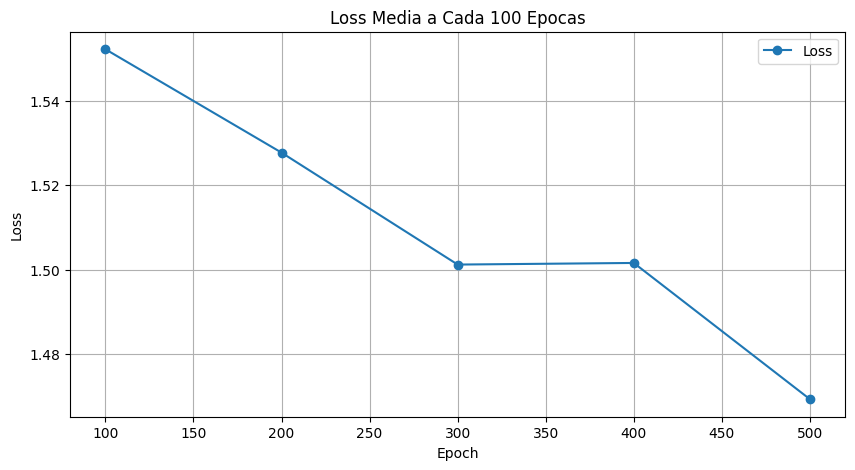

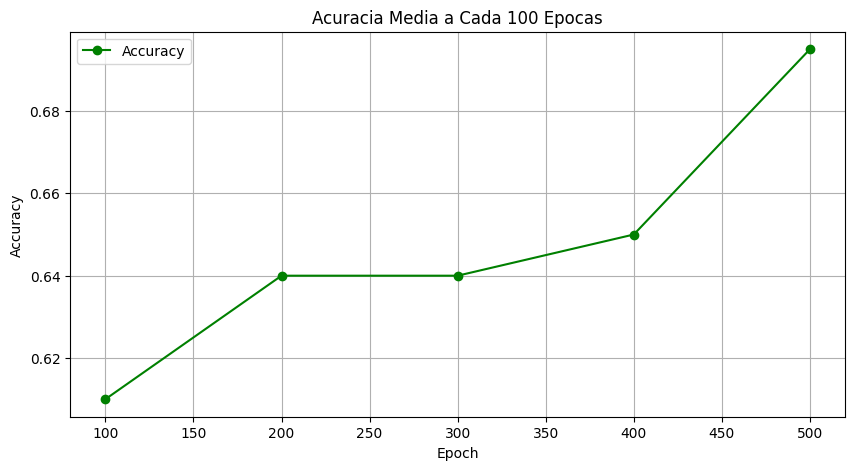

In [13]:
epochs = [metric[0] for metric in logging]
losses = [metric[1] for metric in logging]
accuracies = [metric[2] for metric in logging]

plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o', label="Loss")
plt.title(f"Loss Media a Cada {log_every_n_epochs} Epocas")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, marker='o', color='green', label="Accuracy")
plt.title(f"Acuracia Media a Cada {log_every_n_epochs} Epocas")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

## Evaluation

In [14]:
n_correct = 0
n_total = 0

model.eval()
for _ in range(400):
    # pega uma task com classes de TESTE
    train_loader, test_loader, classes = manager.get_eval_task()

    for train_batch, test_batch in zip(train_loader, test_loader):
        train_imgs, train_labels = train_batch
        test_imgs, test_labels = test_batch

        # undo one-hot encoding
        train_labels = train_labels.argmax(1)
        test_labels = test_labels.argmax(1)

        train_imgs, train_labels = train_imgs.to(device), train_labels.to(device)
        test_imgs, test_labels = test_imgs.to(device), test_labels.to(device)

        scores = model(train_imgs, train_labels, test_imgs)

        n_correct += (scores.argmax(1) == test_labels).sum().item()
        n_total += len(test_labels)

acc = n_correct / n_total
print(f"Accuracy: {acc:.4f}")

# 2way 5 shot

# RESNET
# 1000:
# 900: 0.6600
# 800: 0.6725
# 700: 0.6850
# 600: 0.7075
# 500: 0.6763
# 400: 0.6500
# 300: 0.6338
# 200: 0.6450
# 100: 0.6238

# VIT
# 1000: 0.6613
# 900: 0.6613
# 800: 0.6737
# 600: 0.6550
# 400: 0.6500


# 2way 20 shot
# RESNET
# 800: 0.6400
# 600: 0.6725
# 500: 0.6913


Accuracy: 0.5613


| Models   | 2-Way-5-Shot | 2-Way-10-Shot | 2-Way-20-Shot | 3-Way-5-Shot | 3-Way-10-Shot | 3-Way-20-Shot |
| -------- | ------------ | ------------- | ------------- | ------------ | ------------- | ------------- |
| ResNet50 | 64.00        | 0.6450         | 70.75         |         |          |          |
| ViT      |         |          |          |         |          |          |
| Swin     |         |          |          |         |          |          |
